<a href="https://colab.research.google.com/github/pbuslaev/test_ipynb/blob/main/test_user_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook has to be run on Google colab

<a target="_blank" href="https://colab.research.google.com/github/pbuslaev/test_ipynb/blob/main/test_user_input.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#@title Conda installation
%%capture
!pip install -q condacolab
import condacolab
condacolab.install()

In [2]:
#@title Intall packages
%%capture
!pip install dimorphite_dl --upgrade
!mamba install -c conda-forge rdkit sympy openff-toolkit

In [1]:
#@title Import packages
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = 300,300
from IPython.display import SVG
from dimorphite_dl import DimorphiteDL

from openff.toolkit import Molecule, Topology, ForceField

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
  get_ipython().events.register('pre_run_cell', set_css)

This is Molecule 0


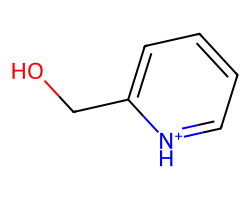

This is Molecule 1


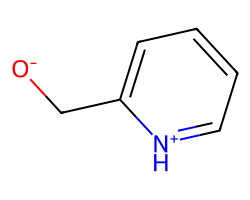

This is Molecule 2


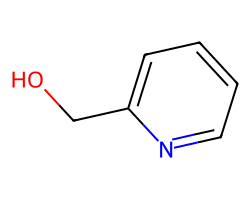

This is Molecule 3


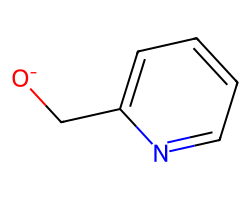

In [74]:
#@title Input molecule
#@markdown Please provide molecule SMILES. We will generate its protonation
#@markdown states. Also, specify pH range for which to create states.
# As a two state example we will use SM-26 from SAMP7 challenge
# (https://github.com/samplchallenges/SAMPL7/tree/master/physical_property)
# SMILES: O=S(CCC1=CC=CC=C1)(NC(C)=O)=O
# pKa = 4.91
# (https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.pdf)
smiles = "c1ccc(CO)nc1" #@param {type: "string"}
min_ph = -10 #@param {type: "number"}
max_ph = 24 #@param {type: "number"}
dimorphite_dl = DimorphiteDL(
    min_ph=min_ph,
    max_ph=max_ph,
    max_variants=256,
    label_states=False,
    pka_precision=0.1
)
mols = [Chem.MolFromSmiles(mol) for mol in dimorphite_dl.protonate(smiles)]
mols = sorted(mols, key = lambda x: Chem.GetFormalCharge(x), reverse=True)
# Now mols[0] is the highest protonation state
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [53]:
#@title Select molecules
#@markdown Which molecule states do you want to use?
#@markdown The molecule ids are shown in the previous cell.
mol1 = True #@param {type:"boolean"}
mol2 = True #@param {type:"boolean"}
mol3 = True #@param {type:"boolean"}
mol4 = True #@param {type:"boolean"}
mol5 = False #@param {type:"boolean"}
mol6 = False #@param {type:"boolean"}
mol7 = False #@param {type:"boolean"}
mol8 = False #@param {type:"boolean"}
mol9 = False #@param {type:"boolean"}
mol10 = False #@param {type:"boolean"}

mols_to_use = [
    mol1, mol2, mol3, mol4, mol5, mol6, mol7, mol8, mol9, mol10,
][:len(mols)]

mols = [mols[i] for i in range(len(mols)) if mols_to_use[i]]

This is Molecule 0


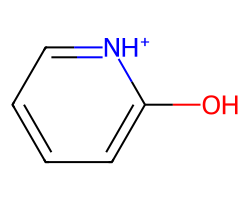

This is Molecule 1


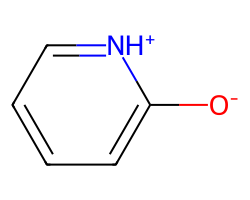

This is Molecule 2


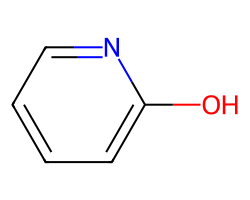

This is Molecule 3


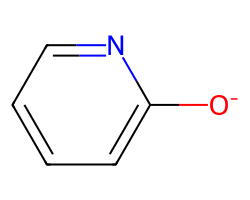

In [54]:
#@title Selected molecules
#@markdown The foloweing molecules will be used in the furhter analysis.
for i, m in enumerate(mols):
    print(f"This is Molecule {i}")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))

In [56]:
#@title Get titratable site
# Highest protonation state is always in state[0]
titratable_sites = []
pmol = mols[0]
for m in mols[1:]:
    from rdkit.Chem import rdFMCS
    res = rdFMCS.FindMCS([pmol, pmol])
    similar_patt = Chem.MolFromSmarts(res.smartsString)
    subst_matches_pmol = pmol.GetSubstructMatches(similar_patt)[0]
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    for a0, a in zip(subst_matches_pmol, subst_matches):
        if (pmol.GetAtomWithIdx(a0).GetFormalCharge() !=
            m.GetAtomWithIdx(a).GetFormalCharge()
        ):
            titratable_sites.append(a0)
titratable_sites = list(set(titratable_sites))

In [57]:
titratable_sites

[0, 6]

In [58]:
#@title Get list of symmetrical titratable sites
from rdkit.Chem import rdFMCS
res = rdFMCS.FindMCS([pmol, pmol])
similar_patt = Chem.MolFromSmarts(res.smartsString)
subst_matches = pmol.GetSubstructMatches(similar_patt, uniquify=False)
print(subst_matches)
symmetrical_sites = {x.GetIdx():[x.GetIdx()] for x in pmol.GetAtoms()}
if len(subst_matches) > 1:
    for sm in subst_matches[1:]:
        for ts in titratable_sites:
            if sm[subst_matches_pmol.index(ts)] not in symmetrical_sites[ts]:
                symmetrical_sites[ts].append(sm[subst_matches_pmol.index(ts)])
                symmetrical_sites[sm[subst_matches_pmol.index(ts)]].append(ts)
symmetrical_sites

((0, 1, 2, 3, 4, 5, 6),)


{0: [0], 1: [1], 2: [2], 3: [3], 4: [4], 5: [5], 6: [6]}

In [59]:
#@title Get list of sites with multiple hydrogens
sites_with_multiple_hs = []
for ts in titratable_sites:
    if (
        pmol.GetAtomWithIdx(ts).GetNumExplicitHs()
        + pmol.GetAtomWithIdx(ts).GetNumImplicitHs()
        > 1
    ):
        sites_with_multiple_hs.append(ts)
sites_with_multiple_hs

[]

In [60]:
#@title Highlight sites with multiple hydrogens
if sites_with_multiple_hs:
    print(
        f"We detected {len(sites_with_multiple_hs)} sites to which multiple "
        + "hydrogens are attached. Please, take a careful look and let us know "
        + "whether we should consider those sites as multisite with each "
        + "hydrogen titrating separately, or as single site, where only one "
        + "hydrogen is titrated. Note, that we highlight the titratable sites "
        + "for the molecule in the highest protonation state, The ."
    )
    colors = [(1.0, 0.0, 0.0, 0.2)]
    for i, a in enumerate(sites_with_multiple_hs):
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', str(i+1))
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    at_highlights = {x: [colors[0]] for x in sites_with_multiple_hs}
    at_rads = {x: 0.5 for x in sites_with_multiple_hs}
    d2d.DrawMoleculeWithHighlights(pmol,"", at_highlights,{}, at_rads, {})
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    for a in sites_with_multiple_hs:
        (pmol.GetAtomWithIdx(a)).SetProp('atomNote', '')
else:
    mHs = None
    print(
        "No sites to which multiple hydrogens are attached were detected. "
        + " You can skip the next step."
    )

No sites to which multiple hydrogens are attached were detected.  You can skip the next step.


In [ ]:
#@title Select treatment of multi-hydrogen sites
#@markdown Do you want to treat titratable sites with multiple hydrogens
#@markdown attached as single multisite or no? Default is no. If you want
#@markdown to treat those with multisite representation tick the corresponding
#@markdown variable. The id of titratable sites are shown in the previous cell.
multiHs_titratable_site_1 = True #@param {type:"boolean"}
multiHs_titratable_site_2 = False #@param {type:"boolean"}
multiHs_titratable_site_3 = False #@param {type:"boolean"}
multiHs_titratable_site_4 = False #@param {type:"boolean"}
multiHs_titratable_site_5 = False #@param {type:"boolean"}

mHs = [
    multiHs_titratable_site_1,
    multiHs_titratable_site_2,
    multiHs_titratable_site_3,
    multiHs_titratable_site_4,
    multiHs_titratable_site_5,
][:len(sites_with_multiple_hs)]

In [14]:
mHs

In [61]:
#@title Symmetrical states treatment
states = {}  # Dictionary of states and state treatment. Each state has a
# molecule, number of states and number of states for consideration
# NOTE: state treatment should be fixed/changed after user input is provided
for i, m in enumerate(mols):
    from rdkit.Chem import rdFMCS
    res = rdFMCS.FindMCS([pmol, pmol])
    similar_patt = Chem.MolFromSmarts(res.smartsString)
    subst_matches = m.GetSubstructMatches(similar_patt)[0]
    charges = {}
    for a in symmetrical_sites:
        charges[a] = [
            m.GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(a)]
            ).GetFormalCharge()
        ]
        if len(symmetrical_sites[a]) == 1:
            continue
        for idx in symmetrical_sites[a][1:]:
            charges[a].append(
                m.GetAtomWithIdx(
                    subst_matches[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            )
    if all([len(list(set(x))) == 1 for x in charges.values()]):
        states[i] = (m, 1, 1)
        continue
    print(f"For molecule {i} symmetrical states were detected:")
    d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
    d2d.DrawMolecule(m)
    d2d.FinishDrawing()
    display(SVG(d2d.GetDrawingText()))
    print("These are found symmetrical states:")
    atoms_to_change = [x for x in charges if len(charges[x]) > 1]
    atoms_with_dif_charges = [
        x for x in charges if len(charges[x]) == 1 and
        charges[x][0] != pmol.GetAtomWithIdx(x).GetFormalCharge()
    ]
    charge_combinations = list(zip(*[charges[x] for x in atoms_to_change]))
    state_charges = []
    from copy import deepcopy
    for c in charge_combinations:
        m_new = deepcopy(pmol)
        for a in atoms_with_dif_charges:
            m_new.GetAtomWithIdx(a).SetFormalCharge(
                pmol.GetAtomWithIdx(a).GetFormalCharge() - 1
            )
            m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
            )
        for a_charge, a in zip(c, atoms_to_change):
            if a_charge != pmol.GetAtomWithIdx(a).GetFormalCharge():
                m_new.GetAtomWithIdx(a).SetFormalCharge(a_charge)
                m_new.GetAtomWithIdx(a).SetNumExplicitHs(
                    pmol.GetAtomWithIdx(a).GetNumExplicitHs() - 1
                )
        if [x.GetFormalCharge() for x in m_new.GetAtoms()] in state_charges:
            continue
        state_charges.append([x.GetFormalCharge() for x in m_new.GetAtoms()])
        d2d = rdMolDraw2D.MolDraw2DSVG(250, 200)
        colors = [(0.0, 1.0, 0.0, 0.2)]
        at_highlights = {x: [colors[0]] for x in atoms_to_change}
        at_rads = {x: 0.5 for x in atoms_to_change}
        d2d.DrawMoleculeWithHighlights(m_new,"", at_highlights,{}, at_rads, {})
        d2d.FinishDrawing()
        display(SVG(d2d.GetDrawingText()))
    states[i] = (m, len(state_charges), 1)
if all([x[1] == 1 for x in states.values()]):
    ss = None
    print(
        "No symmetrical states were found "
        + " You can skip the next step."
    )

No symmetrical states were found  You can skip the next step.


In [ ]:
#@title Select treatment of symmetrical states
#@markdown Please, select whether to inclue symmetrical states for a molecule
#@markdown or not. If for a particular molecule there are no symmetrical
#@markdown states available, selecting True won't influence the behaviour
use_symmetrical_states_molecule_0 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_1 = True #@param {type:"boolean"}
use_symmetrical_states_molecule_2 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_3 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_4 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_5 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_6 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_7 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_8 = False #@param {type:"boolean"}
use_symmetrical_states_molecule_9 = False #@param {type:"boolean"}

ss = [
    use_symmetrical_states_molecule_0,
    use_symmetrical_states_molecule_1,
    use_symmetrical_states_molecule_2,
    use_symmetrical_states_molecule_3,
    use_symmetrical_states_molecule_4,
    use_symmetrical_states_molecule_5,
    use_symmetrical_states_molecule_6,
    use_symmetrical_states_molecule_7,
    use_symmetrical_states_molecule_8,
    use_symmetrical_states_molecule_9,
][:len(states)]

In [62]:
#@title Update states information
for i, s in zip(states.keys(), states.values()):
    if ss:
        t = ss[i]
    else:
        t = False
    if t:
        states[i] = (s[0], s[1], s[1])
    if mHs:
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches = s[0].GetSubstructMatches(similar_patt)[0]
        factor = 1
        for idx in sites_with_multiple_hs:
            if not mHs[sites_with_multiple_hs.index(idx)]:
                continue
            a = s[0].GetAtomWithIdx(
                subst_matches[subst_matches_pmol.index(idx)]
            )
            a_p = pmol.GetAtomWithIdx(idx)
            if (
                (a.GetNumExplicitHs() + a.GetNumImplicitHs()) !=
                (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
            ):
                factor *= (a_p.GetNumExplicitHs() + a_p.GetNumImplicitHs())
        states[i] = (s[0], s[1], states[i][1] * factor)
states

{0: (<rdkit.Chem.rdchem.Mol at 0x7b5c5aeee8f0>, 1, 1),
 1: (<rdkit.Chem.rdchem.Mol at 0x7b5c5aeee960>, 1, 1),
 2: (<rdkit.Chem.rdchem.Mol at 0x7b5c5aeeeab0>, 1, 1),
 3: (<rdkit.Chem.rdchem.Mol at 0x7b5c5aeee880>, 1, 1)}

We found the following transitions between protonation states:
Transition 0


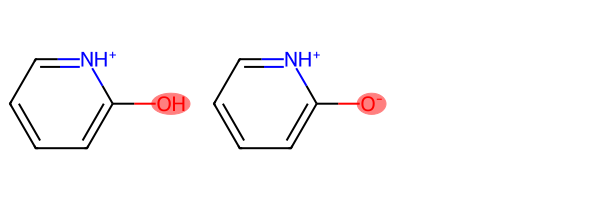

Transition 1


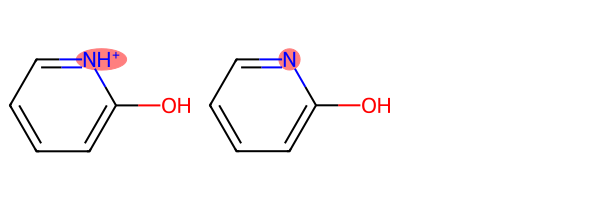

Transition 2


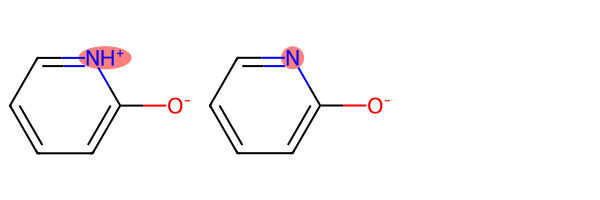

Transition 3


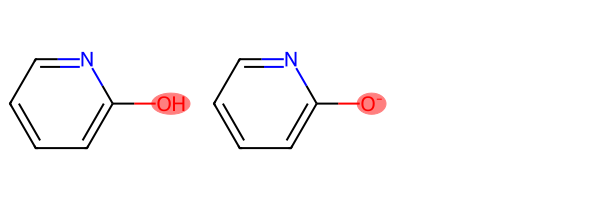

In [63]:
#@title Show state transitions
state_transitions = []
for i, m1 in enumerate(mols):
    for j, m2 in enumerate(mols[i+1:]):
        from rdkit.Chem import rdFMCS
        res = rdFMCS.FindMCS([pmol, pmol])
        similar_patt = Chem.MolFromSmarts(res.smartsString)
        subst_matches1 = m1.GetSubstructMatches(similar_patt)[0]
        subst_matches2 = m2.GetSubstructMatches(similar_patt)[0]
        n_diffs = 0
        for idx in titratable_sites:
            if (
                m1.GetAtomWithIdx(
                    subst_matches1[subst_matches_pmol.index(idx)]
                ).GetFormalCharge() !=
                m2.GetAtomWithIdx(
                    subst_matches2[subst_matches_pmol.index(idx)]
                ).GetFormalCharge()
            ):
                n_diffs += 1
        if n_diffs != 1:
            continue
        state_transitions.append((i, i + 1+j, m1, m2))

def view_difference(mol1, mol2):
    mcs = rdFMCS.FindMCS([mol1,mol2])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = mol1.GetSubstructMatch(mcs_mol)
    match2 = mol2.GetSubstructMatch(mcs_mol)
    target_atm1 = []
    target_atm2 = []
    for a1, a2 in zip(match1, match2):
        if (
            mol1.GetAtomWithIdx(a1).GetFormalCharge() !=
            mol2.GetAtomWithIdx(a2).GetFormalCharge()
        ):
            target_atm1.append(a1)
            target_atm2.append(a2)
    d2d = Draw.MolsToGridImage(
        [mol1, mol2],
        highlightAtomLists=[target_atm1, target_atm2],
        useSVG = True,
    )
    display(d2d)

print("We found the following transitions between protonation states:")
for i, st_t in enumerate(state_transitions):
    print(f"Transition {i}")
    view_difference(st_t[2], st_t[3])

In [64]:
state_transitions

[(0,
  1,
  <rdkit.Chem.rdchem.Mol at 0x7b5c5aeee960>),
 (0,
  2,
  <rdkit.Chem.rdchem.Mol at 0x7b5c5aeeeab0>),
 (1,
  3,
  <rdkit.Chem.rdchem.Mol at 0x7b5c5aeee880>),
 (2,
  3,
  <rdkit.Chem.rdchem.Mol at 0x7b5c5aeee880>)]

In [65]:
#@title Provide pKa values for transitions between protonated states
#@markdown Please, provide pKa values for protonated states.
pka_0 = 2 #@param {type:"number"}
pka_1 = 3 #@param {type:"number"}
pka_2 = 4 #@param {type:"number"}
pka_3 = 5 #@param {type:"number"}
pka_4 = 0.0 #@param {type:"number"}
pka_5 = 0.0 #@param {type:"number"}
pka_6 = 0.0 #@param {type:"number"}
pka_7 = 0.0 #@param {type:"number"}
pka_8 = 0.0 #@param {type:"number"}
pka_9 = 0.0 #@param {type:"number"}

pkas = [
    pka_0, pka_1, pka_2, pka_3, pka_4,
    pka_5, pka_6, pka_7, pka_8, pka_9,
][:len(state_transitions)]

In [66]:
#@title Generate pKa matrix equation
import numpy as np
from sympy import Matrix, MatrixSymbol, symbols
if len(mols) == 2:
    print(f"Single state should be used. pKa = {pkas[0]}")
else:
    ph = symbols("pH")
    A = np.zeros((len(state_transitions) + 1, len(mols)), dtype = 'int')
    b = MatrixSymbol('b', len(state_transitions) + 1, 1).as_explicit()
    bsubs = {b[0,0]: ph}
    for i, (tr, pka) in enumerate(zip(state_transitions, pkas)):
        state1 = tr[0]
        state2 = tr[1]
        n = states[state1][2]
        m = states[state2][2]
        if Chem.GetFormalCharge(tr[2]) > Chem.GetFormalCharge(tr[3]):
            A[i+1, state1] =-1
            A[i+1, state2] = 1
            bsubs[b[i + 1, 0]] = pka - np.log10(n/m) - ph
        else:
            A[i+1, state1] = 1
            A[i+1, state2] = -1
            bsubs[b[i + 1, 0]] = pka - np.log10(m/n) - ph
    A[0, 0] = 1
    m = Matrix(A)
    _, inds = m.T.rref()
    removed_inds = [x for x in range(len(state_transitions) + 1) if x not in inds]
    Ar = A[list(inds)]
    Ad = A[list(removed_inds)]
    mr = Matrix(Ar)
    md = Matrix(Ad)
    p = MatrixSymbol('p', len(mols), 1).as_explicit()
    b = b.subs(bsubs)
    br = MatrixSymbol('br', len(inds), 1).as_explicit()
    brsubs = {}
    for i, idx in enumerate(inds):
        brsubs[br[i, 0]] = b[idx, 0]

    br = br.subs(brsubs)
    br

    sol = mr.solve(br)
    print(
        "Recommended pKa values for protonations states, considering all previous "
        + "input are:"
    )
    for i in range(len(mols)):
        print(f"State {i}: pKa = {sol[i,0]}")

Recommended pKa values for protonations states, considering all previous input are:
State 0: pKa = pH
State 1: pKa = 2.00000000000000
State 2: pKa = 3.00000000000000
State 3: pKa = 6.0 - pH


In [67]:
#@title Topology and structure general behavior
#@markdown Do you want us to generate topology and molecule structure with
#@markdown Open Force Field? If no, you would need to provide topologies in
#@markdown **.itp** format in the following steps.
is_generation_needed = True #@param {type:"boolean"}
ff_to_use = "openff-2.1.0.offxml" #@param {type:"string"}

_mols = []
charges = []
if is_generation_needed:
    ff = ForceField(ff_to_use)
    for _i, m in enumerate(mols):
        _m = Molecule.from_rdkit(m)
        print(Chem.MolToSmiles(_m.to_rdkit()))
        _m.generate_conformers()
        interchange = ff.create_interchange(_m.to_topology())
        charges.append(
            [a.partial_charge.magnitude for a in interchange.topology.atoms]
        )
        _mols.append(_m.to_rdkit())
        if _i == 0:
            interchange.to_gromacs(f"molecule_{_i}")
        else:
            interchange.to_top(f"molecule_{_i}.top")

_base_mol = _mols[0]
charge_table =[charges[0]]
for _m, _c in zip(_mols[1:], charges[1:]):
    mcs = rdFMCS.FindMCS([_base_mol, _m])
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    match1 = _base_mol.GetSubstructMatch(mcs_mol)
    match2 = _m.GetSubstructMatch(mcs_mol)

    _tmp = []
    # if there are permutations required for this molecule, we need to take it
    # into account here.
    for i in range(len(charge_table[0])):
        if i in match1:
            _tmp.append(_c[match1.index(i)])
        else:
            _tmp.append(0)
    charge_table.append(_tmp)

print(np.array(charge_table).T)

# We need to transform top to itp and also for the future
# needs we need the functionality for parsing atoms and
# bonds sections. This will allow us to generate molecular
# graphs, which in turn, will allow us to compare molecules
# and prepare data for constant pH.
"""
We need to support two types of behaviour:
1. Easy case
    We generate molecule our selves with OpenFF.
    In this case we actually know what is the order atoms in
    all protonation states and we can easily do matching.
    We also know what to do with all possible states -
    symmetrical and with multiple hydrogens. From created
    interchanges and topology files we can get all the
    partial charges and then using rdkit and we can generate
    correct charge lists.
    We start by implementing this.
2. More complex case
    The topologies are provided by the user. In this case
    we:
        (i) expect that the user will provide us not only
            with the topologies, but also with structures
            for all states
        (ii) don't expect that the order of atoms is the
            same as in RdKit.
    We will reconstruct the order based on rdkit functionality
    https://greglandrum.github.io/rdkit-blog/posts/2022-12-18-introducing-rdDetermineBonds.html

    NOTE: in principal, the first case can also be treated
    as the second. But we will add it later.
In general, we need to read top/itp files (for now we always
expect [ atoms ] section to be present) and assign charges
in the order of mols[0]. For each state we additionally
treap symmetrical states and multi-H states. Then we change
the order according to the order in the first file.
"""
class GMX_topology:
    """
    Reads gromacs topology file and parses some of the sections.

    Parameters
    ----------
    gmx_top: str
        GROMACS topology file

    Attributes
    ----------
    blocks: Dict[str, str]
        Dictionary of blocks available in the topology file
    atoms: list

    Methods
    -------
    parse_atoms()
        Parse atom section if present. Generates at
    parse_atomtypes()
        Parse atomtypes section if present.
    parse_bonds()
        Parse bonds.


    """
    def __init__(self, gmx_top):
        self.blocks = {}
        with open(gmx_top, "r") as top:
            section = None
            tmp = []
            for line in top:
                if line.strip().startswith("["):
                    if section:
                        if section in self.blocks:
                            self.blocks[section] += [tmp]
                        else:
                            self.blocks[section] = [tmp]
                    else:
                        self.blocks["header"] = [tmp]
                    section = line.strip()[1:-1].strip()
                    tmp = []
                else:
                    tmp += [line]
            if section in self.blocks:
                self.blocks[section] += [tmp]
            else:
                self.blocks[section] = [tmp]

    def parse_atoms(self):
        """
        Parse atoms block. As a result, creates atoms attribute, where for each
        atom in the provided topology atomtype and index are stored
        """
        if "atoms" not in self.blocks:
            self.atoms = []
        else:
            self.atoms = []
            for section in self.blocks["atoms"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    self.atoms.append(
                        (
                            int(line.split()[0]) - 1,
                            line.split()[1],
                        )
                    )

    def parse_dihedrals(self):
        """
        Parse dihedral section of the topology. Only dihdrals of type 1 and 9
        with explicitly provided parameters are taken into account.
        """
        if "dihedrals" not in self.blocks:
            self.dihedrals = []
        else:
            self.dihedrals = []
            for section in self.blocks["dihedrals"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    if len(line.split()) < 8:
                        continue
                    self.dihedrals.append(
                        (
                            int(line.split()[0])-1,
                            int(line.split()[1])-1,
                            int(line.split()[2])-1,
                            int(line.split()[3])-1,
                            line
                        )
                    )

    def parse_dihedraltypes(self):
        """
        Parse dihedraltypes section in the topology if present. Creates
        dihedraltypes attribute, where types and of 4 atoms are provided
        and also the corresponding dihedral string (to ease the search in
        topology file). All imporpers and Fourier dihedrals are for now
        excluded. Thus, only type 1 and 9 are supported.
        https://manual.gromacs.org/current/reference-manual/topologies/topology-file-formats.html

        NOTE: We also should somehow iterate through difened torsions if they
        are present.
        """
        if "dihedraltypes" not in self.blocks:
            self.dihedraltypes = []
        else:
            self.dihedraltypes = []
            for section in self.blocks["dihedraltypes"]:
                for line in section:
                    # Skip non-informative lines
                    if line.strip().startswith(";"):
                        continue
                    if line.strip().startswith("#"):
                        continue
                    if not line.strip():
                        continue
                    if int(line.split()[4]) not in [1, 9]:
                        continue
                    self.dihedraltypes.append(
                        (
                            line.split()[0],
                            line.split()[1],
                            line.split()[2],
                            line.split()[3],
                            line[:(line.rfind(line.split()[3]) + len(line.split()[3]))].strip()
                        )
                    )

[H]Oc1c([H])c([H])c([H])c([H])[n+]1[H]


/usr/local/lib/python3.10/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


[H]c1c([H])c([H])[n+]([H])c([O-])c1[H]
[H]Oc1nc([H])c([H])c([H])c1[H]
[H]c1nc([O-])c([H])c([H])c1[H]
[[-4.53100000e-01 -6.42500000e-01 -6.16383333e-01 -8.32000000e-01]
 [ 2.46800000e-01  5.94500000e-01  6.23516667e-01  9.36300000e-01]
 [-2.15000000e-01 -2.35000000e-01 -2.61383333e-01 -4.29300000e-01]
 [ 3.10000000e-02 -3.90000000e-02 -6.50833333e-02 -4.50000000e-02]
 [-1.65000000e-01 -2.53000000e-01 -2.84383333e-01 -4.65300000e-01]
 [ 7.00000000e-04  1.00000000e-02  4.32116667e-01  4.60200000e-01]
 [-1.22100000e-01 -3.70500000e-01 -7.39083333e-01 -8.47000000e-01]
 [ 4.94000000e-01  0.00000000e+00  2.40166667e-02  0.00000000e+00]
 [ 2.01000000e-01  3.32500000e-01  1.45916667e-01 -4.79000000e-02]
 [ 1.99000000e-01  1.50000000e-01  1.40916667e-01  9.20000000e-02]
 [ 2.07000000e-01  1.50000000e-01  1.59916667e-01  7.30000000e-02]
 [ 2.18000000e-01  1.40000000e-01  4.39916667e-01  1.05000000e-01]
 [ 3.57700000e-01  1.63000000e-01  0.00000000e+00  0.00000000e+00]]


This is Molecule 0


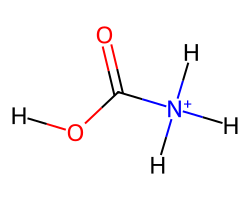

This is Molecule 1


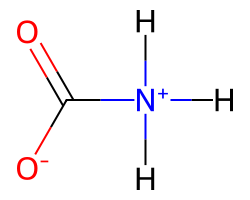

In [ ]:
#@title Provide topologies data
#@markdown If parameterisation is needed, all included molecules will be
#@markdown parameterized with open force field. If not, for all
is_parameterisation_needed = True #@param {type:"boolean"}
included_mols = [m for m,i in zip(mols, incl) if i]
included_svgs = [s for s,i in zip(svgs, incl) if i]
for i, s in enumerate(included_svgs):
    print(f"This is Molecule {i}")
    display(SVG(svgs[i]))

parameters_for_molecule_0 = "" #@param {type:"string"}
parameters_for_molecule_1 = "" #@param {type:"string"}
parameters_for_molecule_2 = "" #@param {type:"string"}
parameters_for_molecule_3 = "" #@param {type:"string"}
parameters_for_molecule_4 = "" #@param {type:"string"}

In [ ]:
from openff.interchange import Interchange

In [ ]:
inter = Interchange.from_smirnoff(force_field=ff, topology=top)

In [ ]:
inter.to_top("test.top")